## Adult Data

** Import the libraries you usually use for data analysis.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report
from mpl_toolkits.mplot3d import Axes3D # 3d scatter plot

%matplotlib inline

In [2]:
# parameters
n_centroids = 2
n_init = 8

In [3]:
# load training set
train = pd.read_csv('./clean_data/adult_train.txt',index_col=False)
train_labels = train['income']
train = train.drop('income',axis=1)

# load testing set
test = pd.read_csv('./clean_data/adult_test.txt',index_col=False)
test_labels = test['income']
test = test.drop('income',axis=1)


In [4]:
# normalize everything such that categoricals are not affected
a = train
train = (a - a.min()) / (a.max() - a.min())
#train = (a - a.mean()) / np.std(a)

b = test
test = (b - b.min()) / (b.max() - b.min())
#test = (b - b.mean()) / np.std(b)


### Apply K Means

In [5]:
kmeans = KMeans(n_clusters=n_centroids, n_init=n_init, n_jobs=4)
kmeans.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=8, n_jobs=4, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[15763  6891]
 [ 1805  5703]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.78     22654
          1       0.45      0.76      0.57      7508

avg / total       0.79      0.71      0.73     30162



### Predicting on test set

In [7]:
b = kmeans.predict(test)

In [8]:
print(confusion_matrix(test_labels, b))
print(classification_report(test_labels, b))

[[7937 3423]
 [ 865 2835]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.79     11360
          1       0.45      0.77      0.57      3700

avg / total       0.79      0.72      0.73     15060



## Choosing number of clusters via silhoutte

In [104]:
from sklearn.metrics import silhouette_samples, silhouette_score
n_seed = 111
nclusters = [2,4,6,8,10,12,14,16,18,20,22]
X = train.values # converting df to np.array
X = X[1:65]
y = train_labels

In [105]:
sil = []
for iclusters in nclusters:
    clusterer = KMeans(n_clusters=iclusters,random_state=n_seed)
    cluster_labels = clusterer.fit_predict(X)
    sil.append(silhouette_score(X, cluster_labels))
    

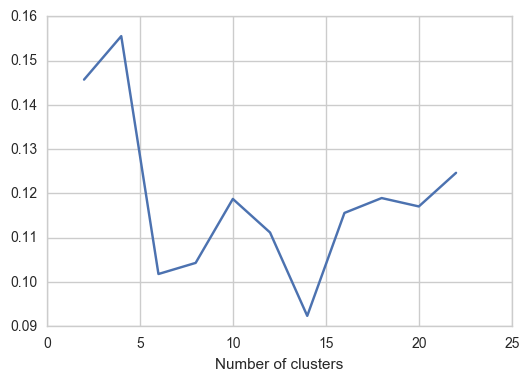

In [109]:
sns.set_style("whitegrid")
plt.plot(nclusters, sil)
plt.ylabel('')
plt.xlabel('Number of clusters') 

### Apply EM

In [13]:
from sklearn.mixture import GaussianMixture
n_init = 2
n_seed = 111

In [14]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=2, precisions_init=None,
        random_state=111, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [15]:
gm_labels = gm.predict(train)

In [16]:
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[15831  6823]
 [ 1821  5687]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.79     22654
          1       0.45      0.76      0.57      7508

avg / total       0.79      0.71      0.73     30162



In [17]:
test_gm = gm.predict(test)
print(confusion_matrix(test_labels, test_gm))
print(classification_report(test_labels, test_gm))

[[7970 3390]
 [ 869 2831]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.79     11360
          1       0.46      0.77      0.57      3700

avg / total       0.79      0.72      0.74     15060



# Note!
**Since training was not provided any information about target feature, it makes sence to see very close accuracy
on both training and testing sets.**

### Apply PCA to Normalized Data 

In [18]:
from sklearn.decomposition import PCA

In [19]:
n_features = len(train.columns)

## Try it on whole data

In [20]:
# when n_comp is given as fraction and svd solver is full, then algorithm chooses # pc components
# such that model explains "n_components= of varience
pca_all = PCA(n_components=0.99,  svd_solver = 'full')
pca_all.fit(train)
pca_n = pca_all.transform(train)

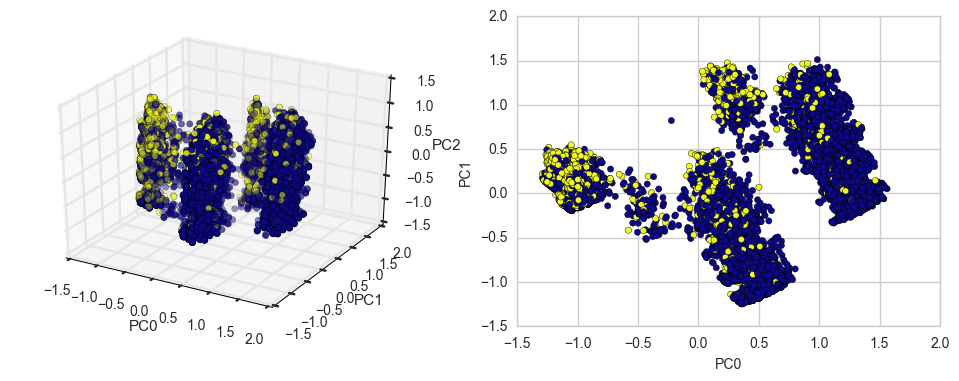

In [21]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_n[:,0], pca_n[:,1],pca_n[:,2],c=train_labels,cmap='plasma')
ax1.set_xlabel('PC0')
ax1.set_ylabel('PC1')
ax1.set_zlabel('PC2')

ax2 = fig.add_subplot(122)
ax2.scatter(pca_n[:,0], pca_n[:,1],c=train_labels,cmap='plasma')
plt.xlabel('PC0', fontsize = 10)
plt.ylabel('PC1', fontsize = 10)


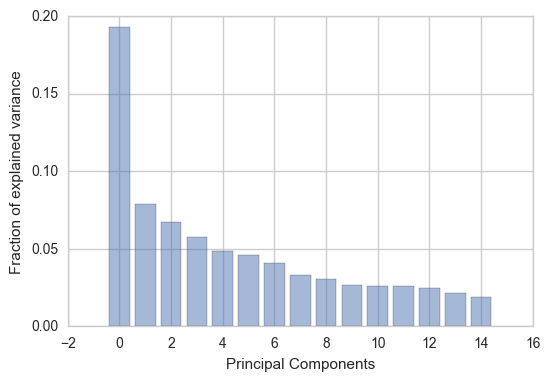

In [22]:
aig_vals = pca_all.explained_variance_ratio_[0:15]
y_pos = np.arange(len(aig_vals))
 
plt.bar(y_pos, aig_vals, align='center', alpha=0.5)
plt.ylabel('Fraction of explained variance')
plt.xlabel('Principal Components') 

In [23]:
#pca_all.explained_variance_ratio_

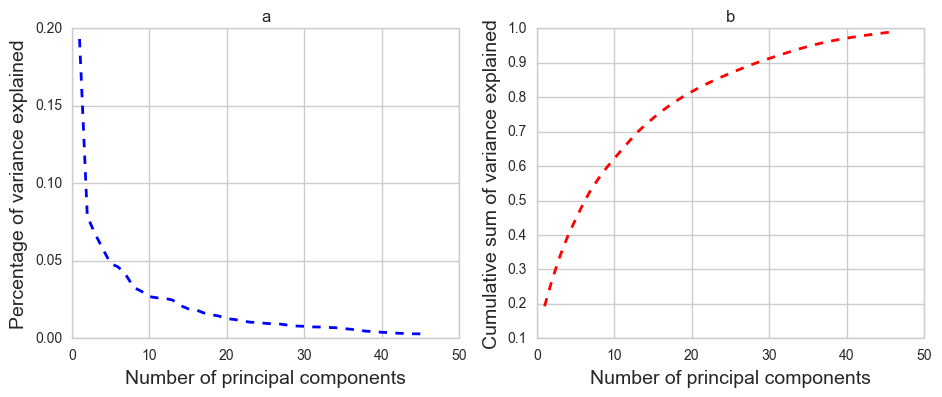

In [24]:
y = pca_all.explained_variance_ratio_
x = np.arange(len(y)) + 1

# plot pca
fig = plt.figure(figsize=(11,4))
sub1 = plt.subplot(121, title = 'a')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Percentage of variance explained', fontsize = 14)
plt.plot(x ,y, '--',lw=2., color='blue')

sub2 = plt.subplot(122, title = 'b')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Cumulative sum of variance explained', fontsize = 14)
plt.plot(x ,np.cumsum(y), '--',lw=2.0, color='red')

### Apply k-means to PCA output

In [25]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(pca_n)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[15764  6890]
 [ 1805  5703]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.78     22654
          1       0.45      0.76      0.57      7508

avg / total       0.79      0.71      0.73     30162



### Apply EM to PCA output

In [26]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(pca_n)
gm_labels = gm.predict(pca_n)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[15876  6778]
 [ 1833  5675]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.79     22654
          1       0.46      0.76      0.57      7508

avg / total       0.79      0.71      0.73     30162

